In [9]:
import numpy as np
import matplotlib.pyplot as plt

def trapezoidal(x, a, b, c, d):
    return np.maximum(np.minimum(np.minimum((x - a) / (b - a + 1e-6), 1), (d - x) / (d - c + 1e-6)), 0)

# Entrada

def temperature(temp):
    return {
        "baixa" : trapezoidal(temp,  0,  0, 10, 20),
        "media" : trapezoidal(temp, 15, 20, 30, 35),
        "alta"  : trapezoidal(temp, 30, 35, 40, 40),
    }

def humidity(hum):
    return {
        "baixa" : trapezoidal(hum,  0,  0, 20, 40),
        "media" : trapezoidal(hum, 30, 40, 60, 70),
        "alta"  : trapezoidal(hum, 60, 80,100,100),
    }

def people(num):
    return {
        "poucas" : trapezoidal(num, 0, 0, 1, 3),
        "media"  : trapezoidal(num, 2, 4, 6, 8),
        "muitas" : trapezoidal(num, 6, 8,10,10),
    }


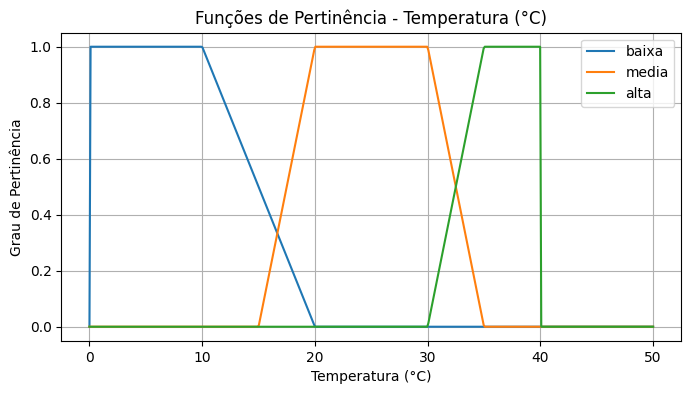

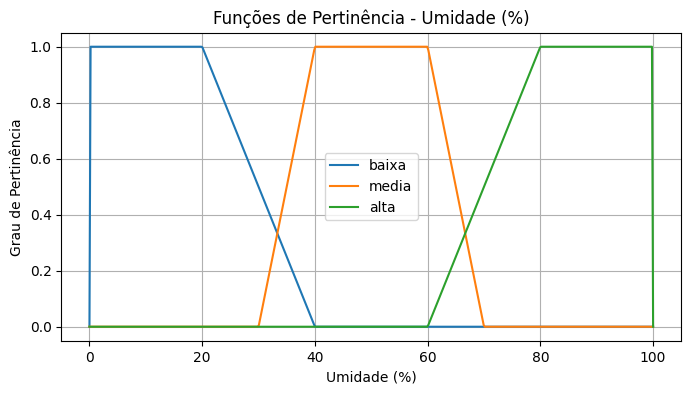

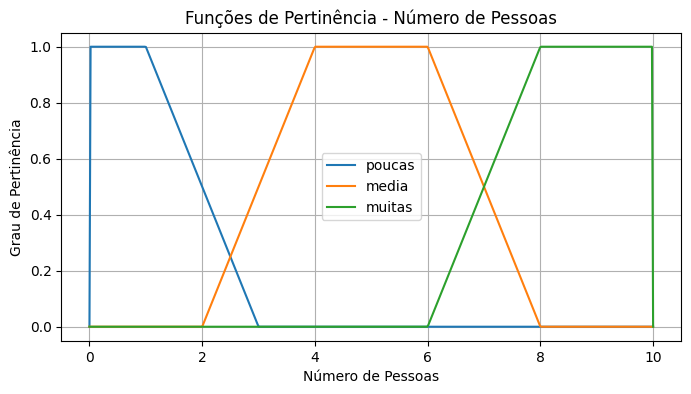

In [10]:
# Função para mostrar funções de pertinência assim que definidas (pode tirar depois se quiserem)

def print_memberships(var_name, universe, memberships):
    plt.figure(figsize=(8, 4))
    for label in memberships:
        values = memberships[label]
        plt.plot(universe, values, label=label)
    plt.title(f'Funções de Pertinência - {var_name}')
    plt.xlabel(var_name)
    plt.ylabel('Grau de Pertinência')
    plt.legend()
    plt.grid(True)
    plt.show()

x_t = np.linspace(0, 50, 500)

#podemos ver a possibilidade de temperatura negativa
# tem que deixar igualmente espaçado?

temperature_labels = {
    "baixa": trapezoidal(x_t, 0, 0, 10, 20),
    "media": trapezoidal(x_t, 15, 20, 30, 35),
    "alta": trapezoidal(x_t, 30, 35, 40, 40),
}

print_memberships("Temperatura (°C)", x_t, temperature_labels)

x_h = np.linspace(0, 100, 500)
humidity_labels = {
    "baixa": trapezoidal(x_h, 0, 0, 20, 40),
    "media": trapezoidal(x_h, 30, 40, 60, 70),
    "alta": trapezoidal(x_h, 60, 80, 100, 100),
}

print_memberships("Umidade (%)", x_h, humidity_labels)

x_p = np.linspace(0, 10, 500)
people_labels = {
    "poucas": trapezoidal(x_p, 0, 0, 1, 3),
    "media": trapezoidal(x_p, 2, 4, 6, 8),
    "muitas": trapezoidal(x_p, 6, 8, 10, 10),
}

print_memberships("Número de Pessoas", x_p, people_labels)

In [11]:
# Saída 

def output_ventilation(x):
    return {
        "fraca": trapezoidal(x, 0, 0, 2.5, 5),
        "moderada": trapezoidal(x, 3, 4.5, 5.5, 7),
        "forte": trapezoidal(x, 6, 7.5, 10, 10),
    }

# Regras

rules = [
    ("alta", "alta", "muitas", "forte"),
    ("alta", "media", "media", "forte"),
    ("alta", "baixa", "poucas", "moderada"),
    ("baixa", "alta", "muitas", "moderada"),
    ("baixa", "media", "media", "fraca"),
    ("baixa", "baixa", "poucas", "fraca"),
]

In [23]:

# Inferência Mamdani

def inferencia_mamdani(temp_val, hum_val, people_val, and_operator="min", or_operator="max"):
    temp_fuzzy = temperature(temp_val)
    hum_fuzzy = humidity(hum_val)
    people_fuzzy = people(people_val)

    output_union = np.zeros(100)
    x_output = np.linspace(0, 10, 100)

    for rule in rules:
        temp_label = rule[0]
        hum_label = rule[1]
        people_label = rule[2]
        output_label = rule[3]

        temp_value = temp_fuzzy[temp_label]
        hum_value = hum_fuzzy[hum_label]
        people_value = people_fuzzy[people_label]

        # Operador AND
        if and_operator == "min":
            activation = min(temp_value, hum_value, people_value)
        elif and_operator == "prod":
            activation = temp_value * hum_value * people_value
        else:
            raise ValueError("Operador AND inválido.")

        output_curve = output_ventilation(x_output)[output_label]
        output_curve = np.minimum(output_curve, activation)

        # Operador OR
        if or_operator == "max":
            output_union = np.maximum(output_union, output_curve)
        elif or_operator == "sum":
            output_union = np.minimum(output_union + output_curve, 1)
        else:
            raise ValueError("Operador OR inválido.")

    return x_output, output_union


# def defuzzify_centroid(x, aggregated):
#     if np.sum(aggregated) == 0:
#         return 0
#     return np.sum(x * aggregated) / np.sum(aggregated)


# Técnica de defuzzificação: Centroide
def defuzzify_centroid(x, aggregated):
    soma_agg = np.sum(aggregated)
    if soma_agg == 0:
        print("\n⚠️ Nenhuma regra foi ativada. Saída definida como 0.")
        return 0

    numerador   = np.sum(x * aggregated)
    denominador = soma_agg
    centroide   = numerador / denominador

    print(f"\n📌 Defuzzificação (Centroide):")
    print(f"Numerador   = ∑(x * μ) = {numerador:.4f}")
    print(f"Denominador = ∑(μ)     = {denominador:.4f}")
    print(f"Centroide   = {centroide:.4f}")

    return centroide


# Técnica de defuzzificação: Média do Máximo
def defuzzify_mean_of_max(x, aggregated):
    max_value = np.max(aggregated)
    indices = np.where(aggregated == max_value)[0]
    mean_of_max = np.mean(x[indices])
    return mean_of_max


# Técnica de defuzzificação: Bissetriz
def defuzzify_bisector(x, aggregated):
    total_area = np.sum(aggregated)
    if total_area == 0:
        print("\n⚠️ Nenhuma regra foi ativada. Saída definida como 0.")
        return 0

    cumulative_area = 0
    for i in range(len(x)):
        cumulative_area += aggregated[i]
        if cumulative_area >= total_area / 2:
            return x[i]



In [24]:
# Simulação

def execute(temp_val, hum_val, people_val, defuzz_method="centroid", and_operator="min", or_operator="max"):
    x, aggregated = inferencia_mamdani(temp_val, hum_val, people_val, and_operator, or_operator)
    
    if defuzz_method == "centroid":
        crisp_output = defuzzify_centroid(x, aggregated)
    elif defuzz_method == "mean_of_max":
        crisp_output = defuzzify_mean_of_max(x, aggregated)
    elif defuzz_method == "bisector":
        crisp_output = defuzzify_bisector(x, aggregated)
    else:
        raise ValueError("Método de defuzzificação inválido.")
    
    plt.figure(figsize=(8, 4))
    plt.plot(x, aggregated, label='Saída Fuzzy')
    plt.axvline(crisp_output, color='r', linestyle='--', label=f'Defuzzificado: {crisp_output:.2f}')
    plt.title(f'T={temp_val}°C, H={hum_val}%, P={people_val} → Intensidade={crisp_output:.2f}')
    plt.xlabel('Intensidade da Ventilação')
    plt.ylabel('Grau de Pertinência')
    plt.grid(True)
    plt.legend()
    plt.show()
    
    return crisp_output

cenarios = [
    (38, 90, 9),   # ativa ("alta",  "alta",  "muitas")      → forte
    (36, 50, 5),   # ativa ("alta",  "media", "media")       → forte
    (36, 20, 1),   # ativa ("alta",  "baixa", "poucas")      → moderada
    (10, 90, 9),   # ativa ("baixa", "alta",  "muitas")      → moderada
    (10, 50, 5),   # ativa ("baixa", "media", "media")       → fraca
    (10, 20, 1),   # ativa ("baixa", "baixa", "poucas")      → fraca
]


# for temp_val, hum_val, people_val in cenarios:
#     execute(temp_val, hum_val, people_val)

In [ ]:

# variando operadores AND e OR

for temp_val, hum_val, people_val in cenarios:
    print(f"\nCenário: T={temp_val}°C, H={hum_val}%, P={people_val}")
    print("Centroide com AND=min, OR=max:")
    execute(temp_val, hum_val, people_val, defuzz_method="centroid", and_operator="min", or_operator="max")
    print("Centroide com AND=prod, OR=sum:")
    execute(temp_val, hum_val, people_val, defuzz_method="centroid", and_operator="prod", or_operator="sum")


Cenário: T=38°C, H=90%, P=9
Centroide:

📌 Defuzzificação (Centroide):
Numerador   = ∑(x * μ) = 263.5554
Denominador = ∑(μ)     = 31.6768
Centroide   = 8.3201


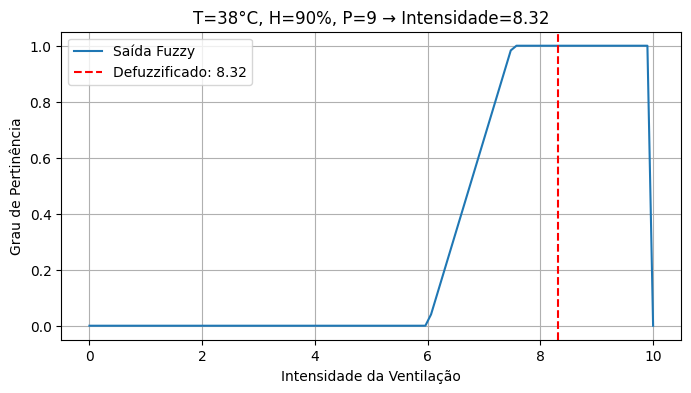

Média do Máximo:


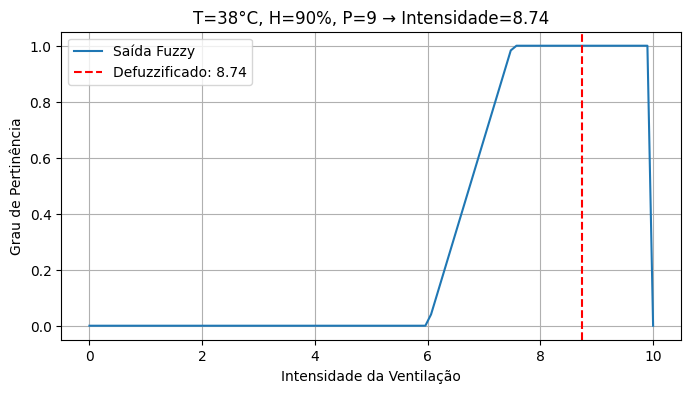

Bissetriz:


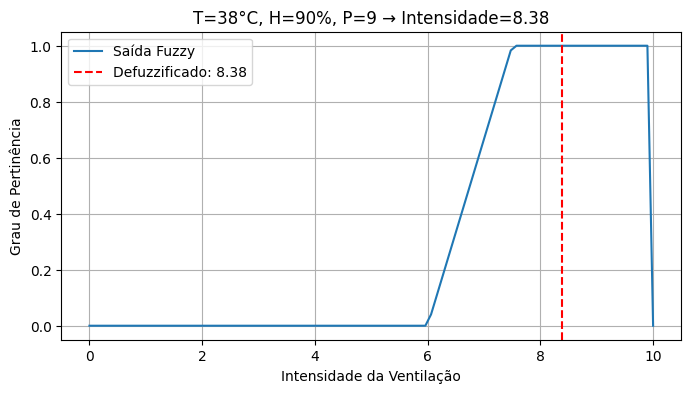


Cenário: T=36°C, H=50%, P=5
Centroide:

📌 Defuzzificação (Centroide):
Numerador   = ∑(x * μ) = 263.5554
Denominador = ∑(μ)     = 31.6768
Centroide   = 8.3201


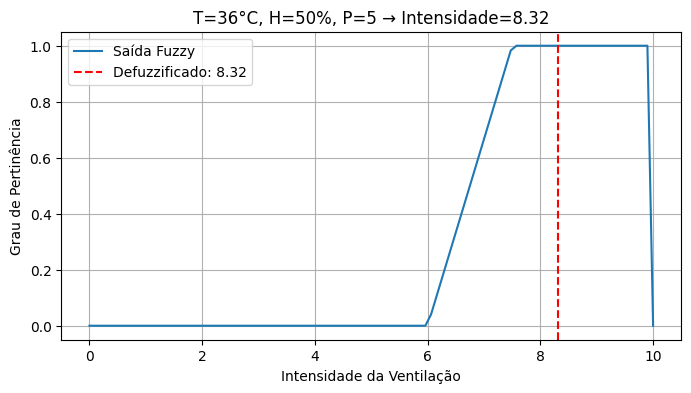

Média do Máximo:


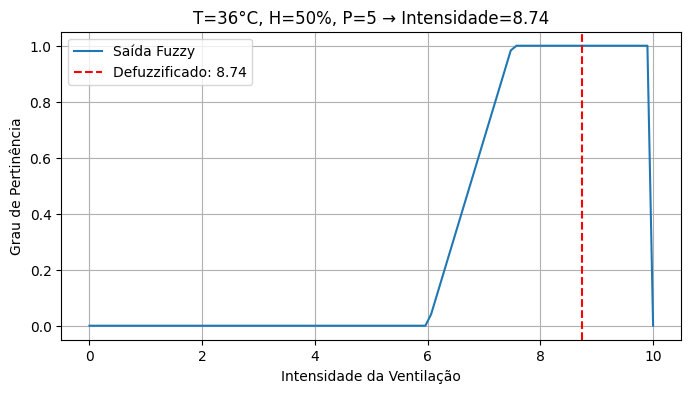

Bissetriz:


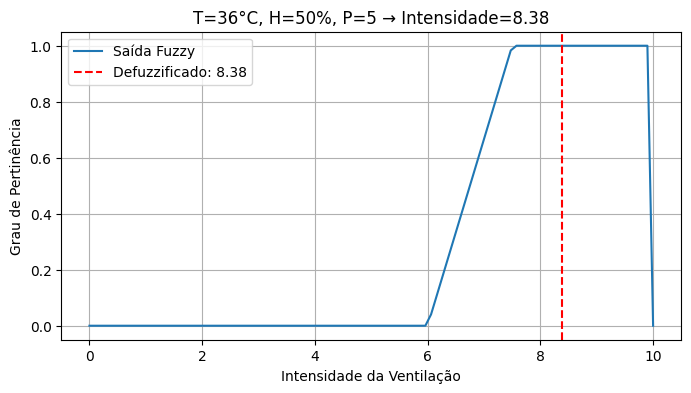


Cenário: T=36°C, H=20%, P=1
Centroide:

📌 Defuzzificação (Centroide):
Numerador   = ∑(x * μ) = 123.7373
Denominador = ∑(μ)     = 24.7475
Centroide   = 5.0000


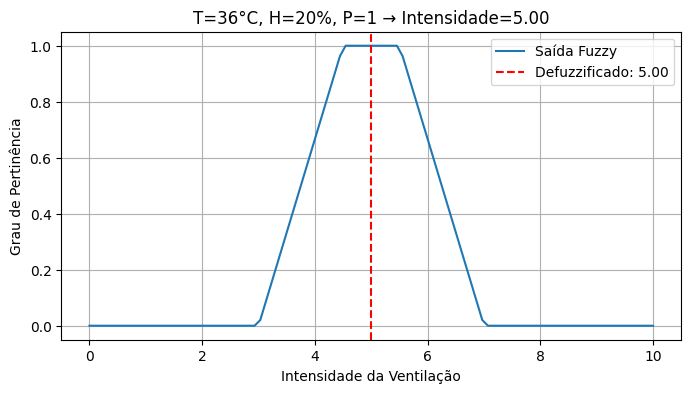

Média do Máximo:


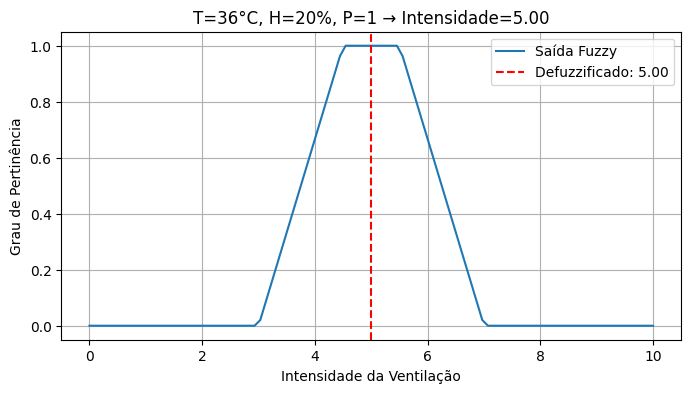

Bissetriz:


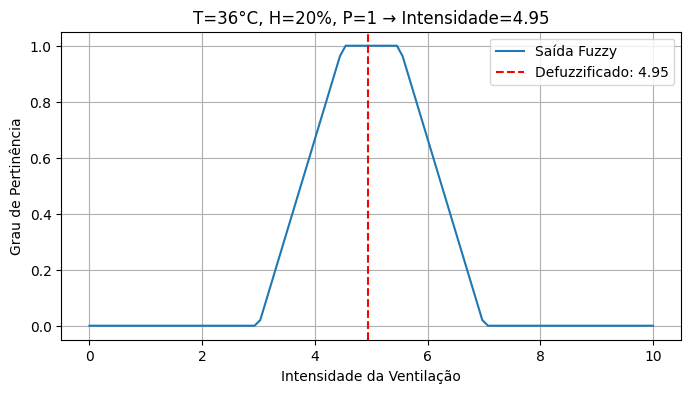


Cenário: T=10°C, H=90%, P=9
Centroide:

📌 Defuzzificação (Centroide):
Numerador   = ∑(x * μ) = 123.7373
Denominador = ∑(μ)     = 24.7475
Centroide   = 5.0000


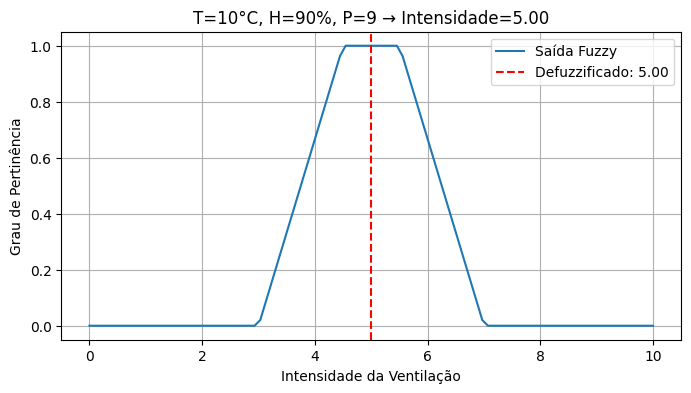

Média do Máximo:


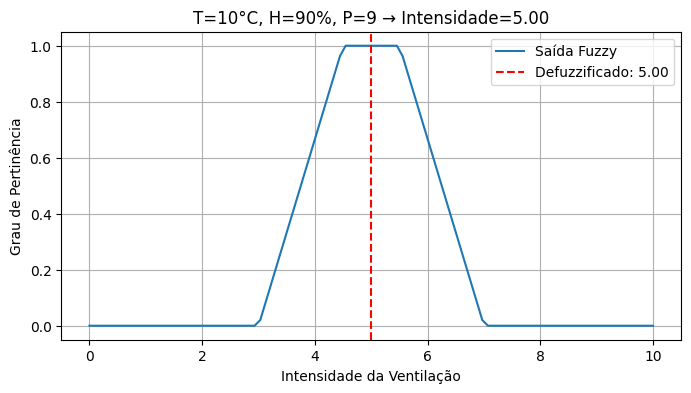

Bissetriz:


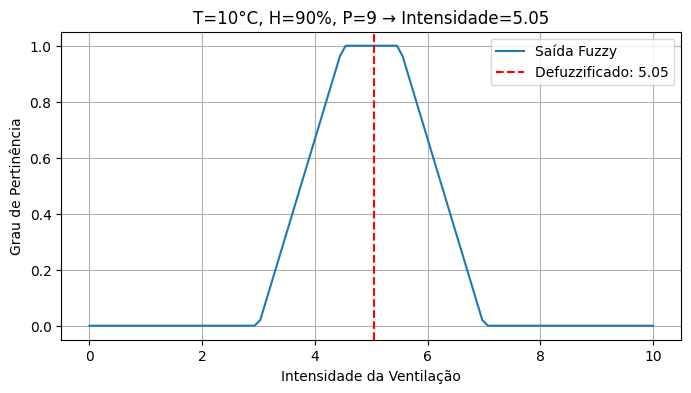


Cenário: T=10°C, H=50%, P=5
Centroide:

📌 Defuzzificação (Centroide):
Numerador   = ∑(x * μ) = 72.1865
Denominador = ∑(μ)     = 36.6263
Centroide   = 1.9709


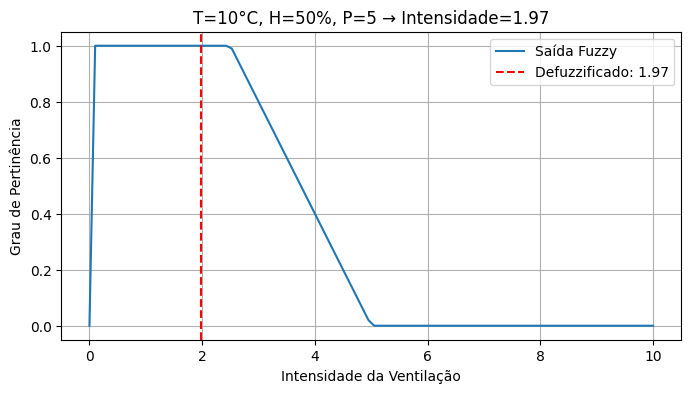

Média do Máximo:


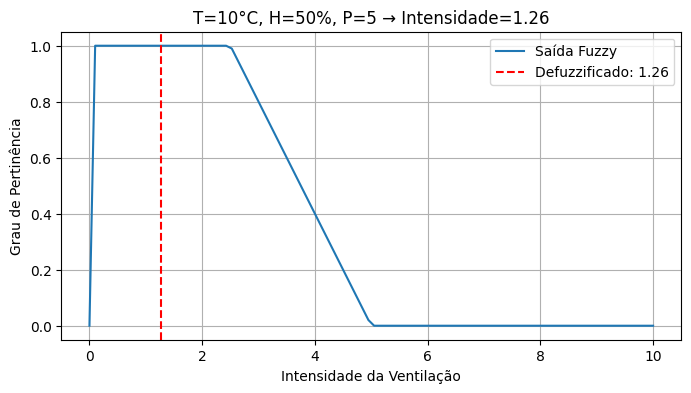

Bissetriz:


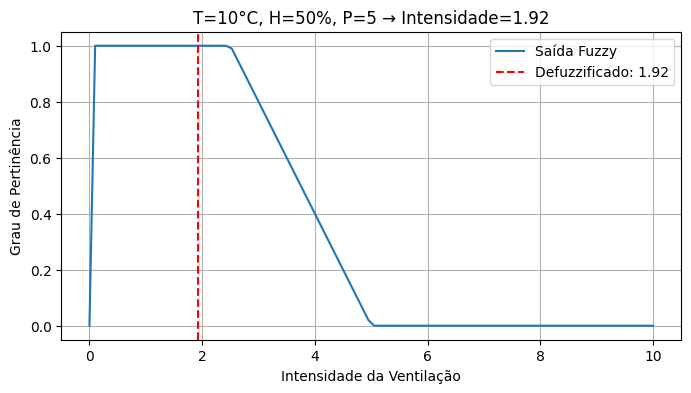


Cenário: T=10°C, H=20%, P=1
Centroide:

📌 Defuzzificação (Centroide):
Numerador   = ∑(x * μ) = 72.1865
Denominador = ∑(μ)     = 36.6262
Centroide   = 1.9709


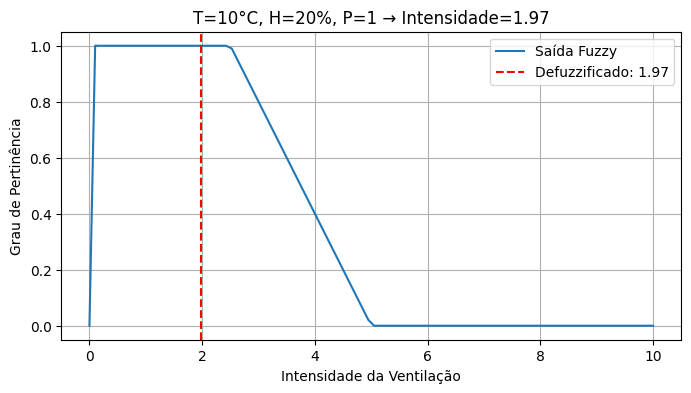

Média do Máximo:


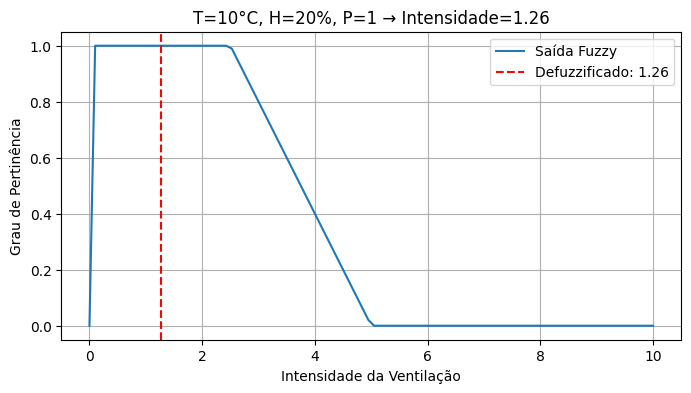

Bissetriz:


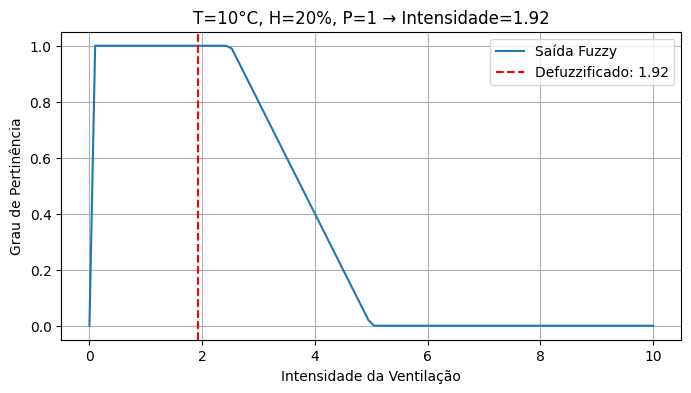

In [ ]:
# variando desfuzzificação
for temp_val, hum_val, people_val in cenarios:
    print(f"\nCenário: T={temp_val}°C, H={hum_val}%, P={people_val}")
    print("Centroide:")
    execute(temp_val, hum_val, people_val, defuzz_method="centroid")
    print("Média do Máximo:")
    execute(temp_val, hum_val, people_val, defuzz_method="mean_of_max")
    print("Bissetriz:")
    execute(temp_val, hum_val, people_val, defuzz_method="bisector")